In [1]:
import collections
import pickle
import torch
import wandb

api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": "vim2"},
                     {"config.aggregator": "downsample"},
                     {"config.pca": 500},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

print("Found %i" % len(runs))
for run in runs:
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
    
    unique_name = f"{run.config['features']}_res{run.config['width']}_layer{run.config['layer']:02}"
    if unique_name in archives:
        continue
        
    print(unique_name)
    for file in run.files():
        if file.name == 'results.pkl':
            file.download(replace=True)
            
    with open('results.pkl', 'rb') as f:
        results = pickle.load(f)
        
    archives[unique_name] = {'corrs_report': results['corrs_report'],
                             'config': run.config}


Found 126
ShallowMonkeyNet_res112_layer01
ShallowMonkeyNet_res112_layer00
r2plus1d_18_res224_layer16
r2plus1d_18_res224_layer15
r2plus1d_18_res224_layer14
r2plus1d_18_res224_layer13
r2plus1d_18_res224_layer12
r2plus1d_18_res224_layer11
r2plus1d_18_res224_layer10
r2plus1d_18_res224_layer09
r2plus1d_18_res224_layer08
r2plus1d_18_res224_layer07
r2plus1d_18_res224_layer06
r2plus1d_18_res224_layer05
r2plus1d_18_res224_layer04
r2plus1d_18_res224_layer03
r2plus1d_18_res224_layer02
r2plus1d_18_res224_layer01
r2plus1d_18_res224_layer00
mc3_18_res112_layer16
mc3_18_res112_layer15
mc3_18_res112_layer14
mc3_18_res112_layer13
mc3_18_res112_layer12
mc3_18_res112_layer11
mc3_18_res112_layer10
mc3_18_res112_layer09
mc3_18_res112_layer08
mc3_18_res112_layer07
mc3_18_res112_layer06
mc3_18_res112_layer05
mc3_18_res112_layer04
mc3_18_res112_layer03
mc3_18_res112_layer02
mc3_18_res112_layer01
mc3_18_res112_layer00
r3d_18_res112_layer16
r3d_18_res112_layer15
r3d_18_res112_layer14
r3d_18_res112_layer13
r3d_1

In [114]:
file.name

'wandb-summary.json'

In [107]:
results[2]

{'key': 'SlowFast_Slow_res224_layer17',
 'voxel': 2,
 'features': 'SlowFast_Slow_res224',
 'family': 'SlowFast',
 'layer': 17,
 'report_corr': -0.0054405252,
 'area': 'VO'}

In [2]:
import sys
sys.path.append('../')
import fmri_models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from python_dict_wrapper import wrap
import torch
import seaborn as sns

data = fmri_models.get_dataset(
    wrap({'dataset': 'vim2',
          'data_root': '../data',
          'subject': 's1',
          'subset': False}), 'report')
max_r2 = data.max_r2[data.mask]
max_r = np.sqrt(np.fmax(max_r2, 0))

roi_str = np.zeros(data.mask.shape, dtype=np.object)
for key, val in data.rois.items():
    roi_str[(val > 0).ravel()] = key
rois = roi_str[data.mask]

families = {'I3D': 'SlowFast',
            'MotionNet': 'shallow',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet': 'control',
            'resnet18': 'control',
            'ShiftNet': 'control'}

results = []
for k, v in archives.items():
    for i, el in enumerate(v['corrs_report']):
        fam = families[v['config']['features']]
        results.append({'key': k, 
                        'voxel': i,
                        'features': v['config']['features'] + '_res' + str(v['config']['width']),
                        'family': fam,
                        'layer': v['config']['layer'],
                        'report_corr': el,
                        'max_r': max_r[i],
                        'area': rois[i][:-2]})

df = pd.DataFrame(results)
df = df.sort_values('key')

In [22]:
df.key.unique()

array(['MotionNet_res112_layer00', 'ShiftNet_res112_layer00',
       'ShiftNet_res112_layer01', 'ShiftNet_res112_layer02',
       'ShiftNet_res112_layer03', 'ShiftNet_res112_layer04',
       'ShiftNet_res112_layer05', 'SlowFast_Fast_res224_layer00',
       'SlowFast_Fast_res224_layer01', 'SlowFast_Fast_res224_layer02',
       'SlowFast_Fast_res224_layer03', 'SlowFast_Fast_res224_layer04',
       'SlowFast_Fast_res224_layer05', 'SlowFast_Fast_res224_layer06',
       'SlowFast_Fast_res224_layer07', 'SlowFast_Fast_res224_layer08',
       'SlowFast_Fast_res224_layer09', 'SlowFast_Fast_res224_layer10',
       'SlowFast_Fast_res224_layer11', 'SlowFast_Fast_res224_layer12',
       'SlowFast_Fast_res224_layer13', 'SlowFast_Fast_res224_layer14',
       'SlowFast_Fast_res224_layer15', 'SlowFast_Fast_res224_layer16',
       'SlowFast_Fast_res224_layer17', 'SlowFast_Slow_res224_layer00',
       'SlowFast_Slow_res224_layer01', 'SlowFast_Slow_res224_layer02',
       'SlowFast_Slow_res224_layer03', '

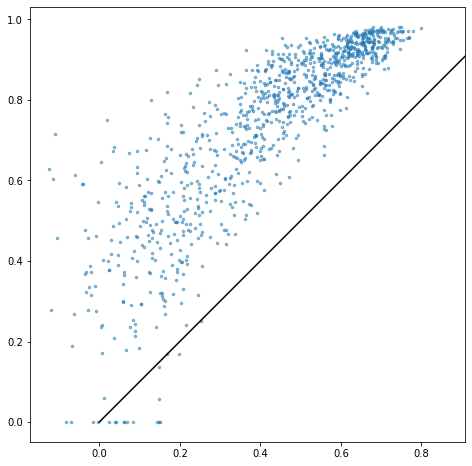

In [31]:
max_r = df.query('key == "Slow_res224_layer10" and area == "v1"').max_r
report_corr = df.query('key == "Slow_res224_layer10" and area == "v1"').report_corr

plt.figure(figsize=(8, 8))
plt.plot(report_corr, max_r, '.', markersize=5, alpha=0.5)
plt.axis('square')
plt.plot([0, 1], [0, 1], 'k-')

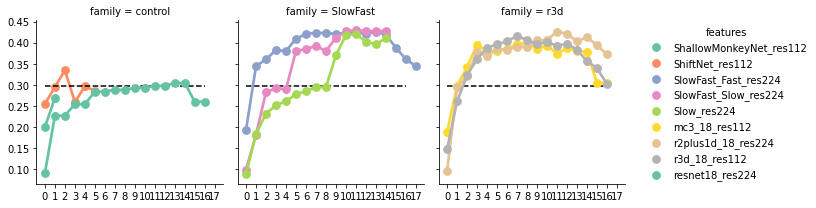

In [3]:
df['relative_r'] = df.report_corr / df.max_r
m = df.query('family == "shallow" and max_r >= 0.2').relative_r.mean()

def annotate(data, **kws):
    ax = plt.gca()
    # Plot the shallow baseline
    ax.plot([0, 16], [m, m], 'k--')
    

g = sns.catplot(x='layer', 
             y='relative_r', 
             hue='features',
             col='family', 
             kind='point',
             palette="Set2",
             data=df.query('family != "shallow" and max_r >= 0.2'),
             height=3,
             legend_outside=False)
g.map_dataframe(annotate)

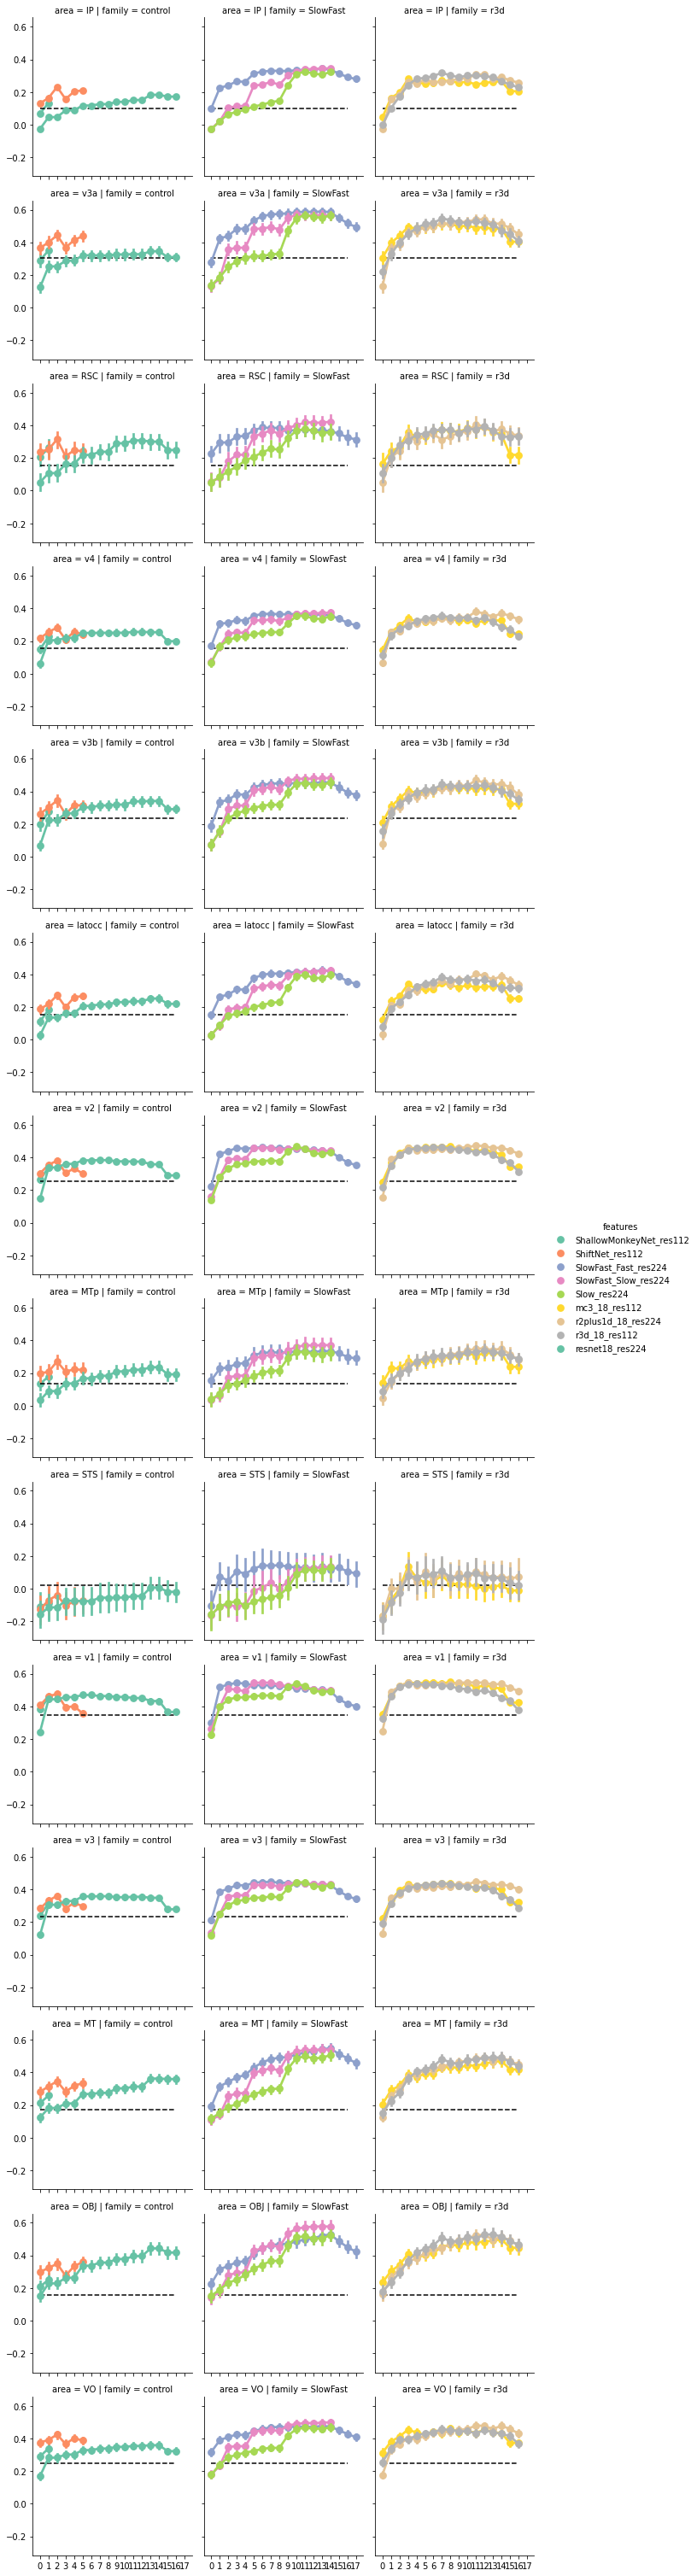

In [4]:
m = df.query('family == "shallow"').groupby('area').report_corr.mean()
def annotate(data, **kws):
    ax = plt.gca()
    # Plot the shallow baseline
    baseline = m[data.iloc[0].area]
    ax.plot([0, 16], [baseline, baseline], 'k--')
    
g = sns.catplot(x='layer', 
             y='relative_r', 
             hue='features',
             col='family', 
             row='area',
             kind='point',
             palette="Set2",
             data=df.query('family != "shallow" and max_r >= 0.2'),
             height=3,
             legend_outside=False)
g.map_dataframe(annotate)

In [41]:
df_2d.relative_r

Series([], Name: relative_r, dtype: float64)

Text(0.5, 1.0, 'Mean prediction normalized correlation')

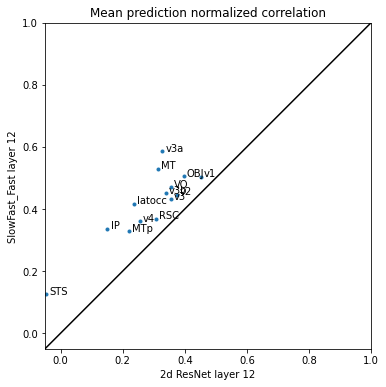

In [45]:
df_3d = df.query('features == "SlowFast_Fast_res224" and layer == 12 and max_r > .2').groupby('area').mean()
df_2d = df.query('features == "resnet18_res224" and layer == 12 and max_r > .2').groupby('area').mean()

plt.figure(figsize=(6, 6))
plt.plot(df_2d.relative_r, df_3d.relative_r, '.')
for i in range(len(df_2d)):
    plt.text(df_2d.relative_r[i]+.01, df_3d.relative_r[i], df_2d.reset_index().area[i])

plt.plot([-1, 1], [-1, 1], 'k-')
plt.axis('square')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.0])

plt.xlabel('2d ResNet layer 12')
plt.ylabel('SlowFast_Fast layer 12')
plt.title('Mean prediction normalized correlation')

Text(0.5, 1.0, 'Mean prediction normalized correlation')

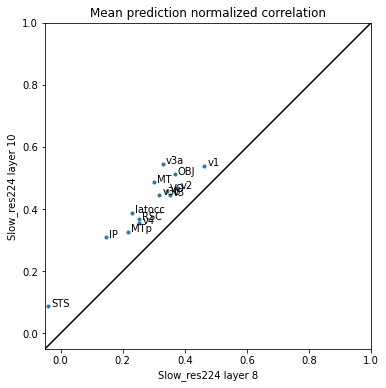

In [50]:
df_3d = df.query('features == "Slow_res224" and layer == 10 and max_r >= .2').groupby('area').mean()
df_2d = df.query('features == "Slow_res224" and layer == 8 and max_r >= .2').groupby('area').mean()

plt.figure(figsize=(6, 6))
plt.plot(df_2d.relative_r, df_3d.relative_r, '.')
for i in range(len(df_2d)):
    plt.text(df_2d.relative_r[i]+.01, df_3d.relative_r[i], df_2d.reset_index().area[i])

plt.plot([-1, 1], [-1, 1], 'k-')
plt.axis('square')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.0])

plt.xlabel('Slow_res224 layer 8')
plt.ylabel('Slow_res224 layer 10')
plt.title('Mean prediction normalized correlation')

In [52]:
df_ = df.query('features == "r3d_18_res112" and max_r > .2')
df_['relative_r_layer'] = df_.apply(lambda x: (x.relative_r, x.layer), axis=1)
df_group = df_.groupby(['voxel']).max()
df_group['best_layer'] = df_group.relative_r_layer.map(lambda x: x[1])

<ipython-input-52-532a77d0b25a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['relative_r_layer'] = df_.apply(lambda x: (x.relative_r, x.layer), axis=1)


In [100]:
df_group

,key,features,family,layer,report_corr,area,report_corr_layer,best_layer
voxel,,,,,,,,
0,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.156603,VO,"(0.15660318732261658, 15)",15
1,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.017595,VO,"(0.017595021054148674, 3)",3
2,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.135669,VO,"(0.13566863536834717, 15)",15
3,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.324614,VO,"(0.3246135711669922, 7)",7
4,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.324310,VO,"(0.32430964708328247, 14)",14
...,...,...,...,...,...,...,...,...
8977,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.107045,v2,"(0.10704535245895386, 10)",10
8978,r3d_18_res112_layer16,r3d_18_res112,r3d,16,-0.014350,v2,"(-0.014349889941513538, 11)",11
8979,r3d_18_res112_layer16,r3d_18_res112,r3d,16,0.031592,v3,"(0.03159164637327194, 5)",5


Text(0.5, 1.0, 'Best layer for each area, r3d')

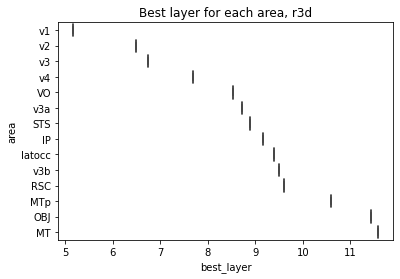

In [53]:
df__ = df_group.query('report_corr > .05').groupby('area').mean().sort_values('best_layer')
sns.boxplot(y='area', 
            x='best_layer', 
            data=df__.reset_index())
plt.title('Best layer for each area, r3d')

<AxesSubplot:xlabel='report_corr', ylabel='key'>

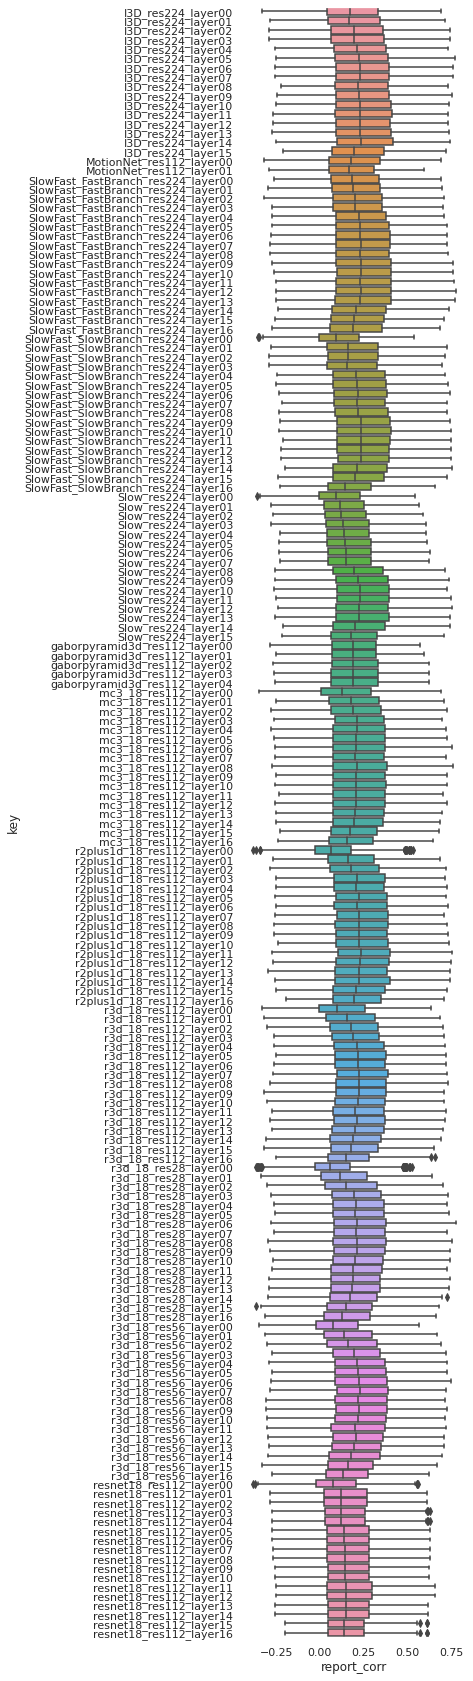

In [39]:
plt.figure(figsize=(4, 30))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.boxplot(y='key', 
            x='report_corr', 
            data=df, ax=plt.gca())

In [19]:
g = sns.catplot(y="key", x="report_corr",
                col="area",
                data=df,
                orient="h", aspect=.6, height=6, palette="Set3",
                kind="box")

(1571850, 3)

In [137]:
import pandas as pd
import seaborn as sns

#plt.figure(figsize=(4, 6))
#sns.boxplot(y='key', x='report_corr', data=df, ax=plt.gca(), hue='area')

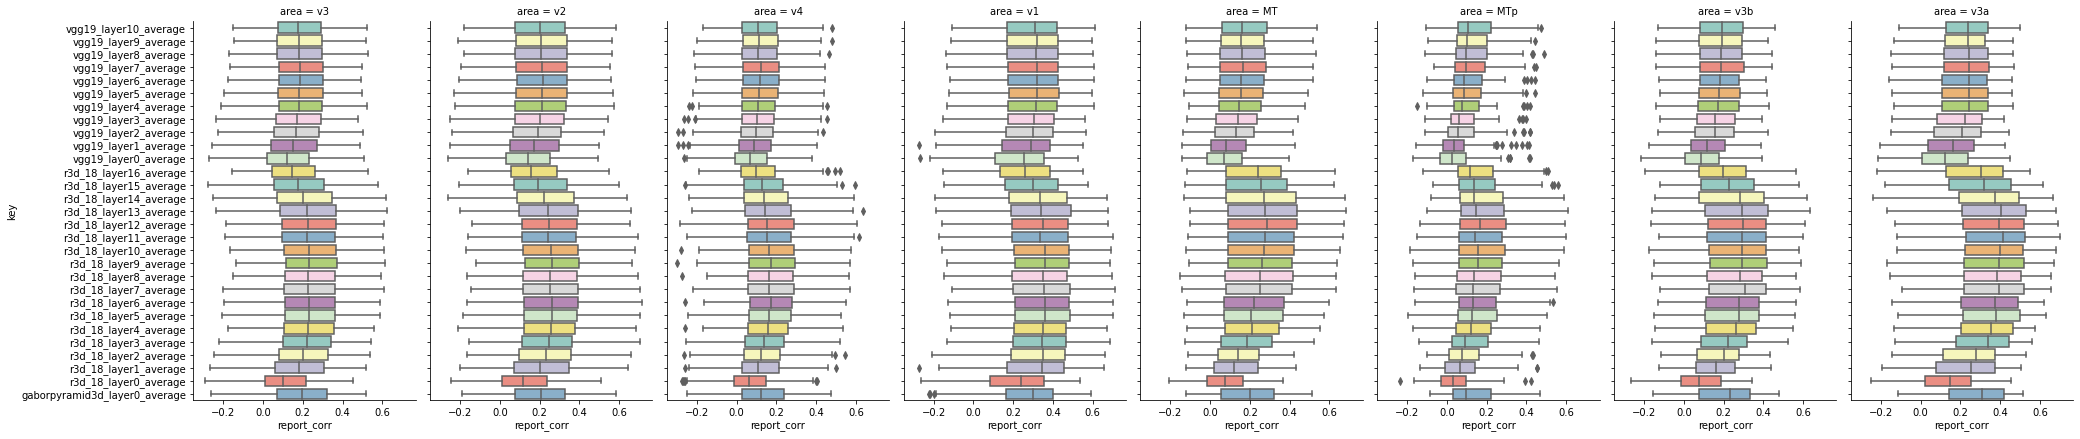

In [138]:
g = sns.catplot(y="key", x="report_corr",
                col="area",
                data=df,
                orient="h", aspect=.6, height=6, palette="Set3",
                kind="box")

In [55]:
from wandb.apis.internal import Api
a = Api()
a.download_urls

r3d_18_layer17_average:0.173
r3d_18_layer16_average:0.199
r3d_18_layer15_average:0.222
r3d_18_layer14_average:0.238
r3d_18_layer13_average:0.241
r3d_18_layer12_average:0.239
r3d_18_layer11_average:0.244
r3d_18_layer10_average:0.249
r3d_18_layer9_average:0.240
r3d_18_layer8_average:0.245
r3d_18_layer7_average:0.240
r3d_18_layer6_average:0.239
r3d_18_layer5_average:0.231
r3d_18_layer4_average:0.219
r3d_18_layer3_average:0.200
r3d_18_layer2_average:0.185
r3d_18_layer1_average:0.110


Text(0.5, 1.0, 'R3D_18 mean report correlation, vim2, map average')

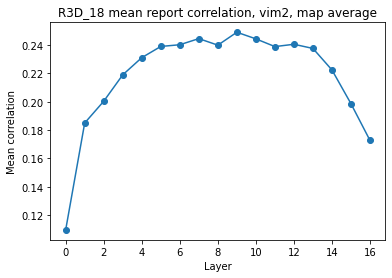

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def mean_from_hist(data):
    x_mean = data['packedBins']['min'] + np.arange(data['packedBins']['count']) * data['packedBins']['size']
    #x_mean = (x_mean[:-1] + x_mean[1:])/2
    the_mean = (x_mean * np.array(data['values'])).sum() / np.array(data['values']).sum()
    return the_mean

ms = []
for key, val in archives.items():
    m = mean_from_hist(val['corrs_report'])
    print(f"{key}:{m:.3f}")
    ms.append(m)
    
plt.plot(np.arange(17), np.array(ms)[::-1], 'o-')
plt.xlabel('Layer')
plt.ylabel('Mean correlation')
plt.title('R3D_18 mean report correlation, vim2, map average')

(-1.1, 1.1)

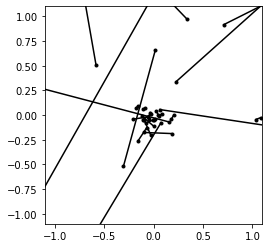

In [171]:
x_all_at_once = archives['gaborpyramid2d'][-1]['weights']['sampler.wx'].cpu().numpy()
x_one_by_one = np.array([archives['gaborpyramid2d'][x]['weights']['sampler.wx'].cpu().numpy() for x in range(25)]).squeeze()
y_all_at_once = archives['gaborpyramid2d'][-1]['weights']['sampler.wy'].cpu().numpy()
y_one_by_one = np.array([archives['gaborpyramid2d'][x]['weights']['sampler.wy'].cpu().numpy() for x in range(25)]).squeeze()
#archives['gaborpyramid2d'][0]['config']['learning_rate']
plt.plot(np.stack([x_all_at_once, x_one_by_one], axis=0), 
         np.stack([y_all_at_once, y_one_by_one], axis=0), 'k.-')
plt.axis('square')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

In [166]:
[x_all_at_once, x_one_by_one]

[array([ 0.18238145,  1.0866314 ,  0.00759659, -0.10613997, -0.71515685,
        -1.459469  ,  1.3236212 , -0.05640861, -0.04596966,  0.34030446,
         2.143676  ,  0.709235  , -0.11134848,  0.00410185,  0.02657548,
        -1.3330803 , -1.6518818 , -0.09665827,  0.08307133, -0.0694584 ,
        -0.30469847, -0.17413002, -1.0483379 ,  0.20523083, -0.07756416],
       dtype=float32),
 array([[-9.9157296e-02],
        [ 1.0336617e+00],
        [-1.2724528e-03],
        [-8.6366288e-02],
        [-5.8164388e-01],
        [ 3.1989318e-01],
        [ 2.2802328e-01],
        [-2.0692144e-01],
        [-3.3334795e-02],
        [-1.0469531e+00],
        [ 6.3262224e-02],
        [ 3.3106732e+00],
        [-2.7937867e-02],
        [-1.1491196e-01],
        [ 4.8468444e-02],
        [ 1.5786837e-01],
        [-1.2929194e+00],
        [-3.0077750e-02],
        [ 5.9524819e-02],
        [-1.5480994e-01],
        [ 1.7667795e-02],
        [-1.5860979e-01],
        [ 7.5761326e-02],
        [ 1.8

Tune correlation, all at once, xception2d: 0.1235
Tune correlation, cell-by-cell, xception2d: 0.1751


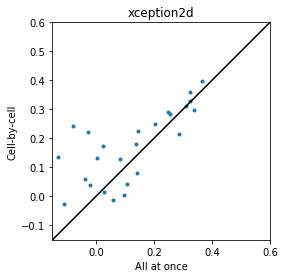

Tune correlation, all at once, gaborpyramid2d: 0.1656
Tune correlation, cell-by-cell, gaborpyramid2d: 0.1860


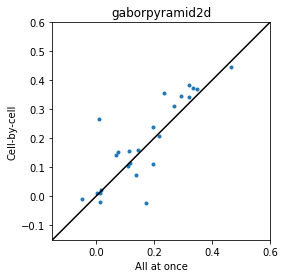

In [143]:
import matplotlib.pyplot as plt

for rep in ['xception2d', 'gaborpyramid2d']:
    tune_corr_all = archives[rep][-1]['tune_corr']
    tune_corr_cell_by_cell = [(k, v['tune_corr']) for k, v in archives[rep].items() if k > -1]
    tune_corr_cell_by_cell = [x[1] for x in sorted(tune_corr_cell_by_cell)]
    plt.plot(tune_corr_all, tune_corr_cell_by_cell, '.')
    plt.plot([-1, 1], [-1, 1], 'k-')
    plt.axis('square')
    plt.xlim((-.15, .6))
    plt.ylim((-.15, .6))
    plt.xlabel('All at once')
    plt.ylabel('Cell-by-cell')
    plt.title(rep)
    print(f"Tune correlation, all at once, {rep}: {np.mean(tune_corr_all):.4f}")
    print(f"Tune correlation, cell-by-cell, {rep}: {np.mean(tune_corr_cell_by_cell):.4f}")
    plt.show()

1
2
3
4
5
6
7
8
9


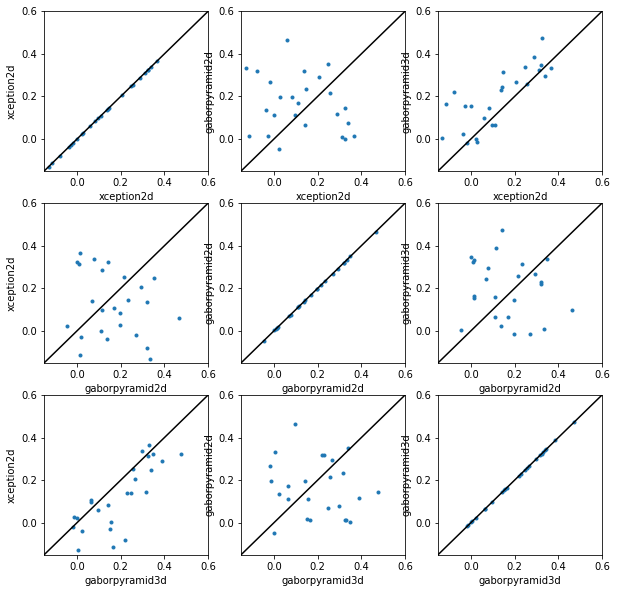

In [187]:
plt.figure(figsize=(10, 10))
reps = ['xception2d', 'gaborpyramid2d', 'gaborpyramid3d']
nrep = 3
for i in range(nrep):
    for j in range(0, nrep):
        rep0 = reps[i]
        rep1 = reps[j]
        plt.subplot(nrep, nrep, 1 + j + i * nrep)
        print(1 + j + i * nrep)
        plt.plot(archives[rep0][-1]['tune_corr'], archives[rep1][-1]['tune_corr'], '.')
        plt.xlabel(rep0)
        plt.ylabel(rep1)
        plt.plot([-1, 1], [-1, 1], 'k-')
        plt.xlim((-.15, .6))
        plt.ylim((-.15, .6))

#for rep in ['xception2d', 'gaborpyramid2d']:
#    tune_corr_all = archives[rep][-1]['tune_corr']

(-0.12, 0.5)

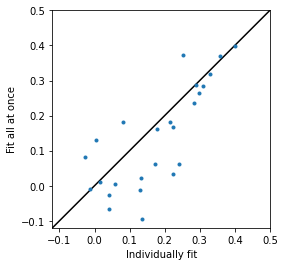

In [112]:
all_at_once = [0.1678023338317871,
               0.37069717049598694,
               0.2859063744544983,
               0.16201408207416534,
               0.1804608851671219,
               0.08193636685609818,
               0.28480473160743713,
               0.18251098692417145,
               0.1291564702987671,
               0.3979525566101074,
               0.26405853033065796,
               0.03389165922999382,
               0.2364319413900375,
               0.0045745414681732655,
               0.02219552919268608,
               -0.06534221768379211,
               0.31926828622817993,
               -0.010949542745947838,
               -0.00940705556422472,
               0.37300461530685425,
               0.01107801217585802,
               -0.094401553273201,
               0.062314119189977646,
               0.06088846176862717,
               -0.027850590646266937]

all_at_once_pretrained = [0.146110400557518,0.32512882351875305,0.2490551471710205,0.13805796205997467,0.2879319489002228,-0.11183082312345503,0.31194233894348145,0.141983300447464,0.0982915461063385,0.36537039279937744,0.3389202356338501,-0.026962850242853165,0.25463470816612244,-0.03682025149464607,0.001990905497223139,0.10854241251945496,0.3230203688144684,0.0827552080154419,0.059587348252534866,0.2049235701560974,0.02760285697877407,-0.12945596873760223,0.02471204660832882,-0.0783606693148613,-0.01916531473398209]
individual = np.array([x['tune_corr'] for x in archives.values()])

plt.plot([-1, 1], [-1, 1], 'k-')
plt.plot(individual[::-1], all_at_once, '.')
plt.xlabel('Individually fit')
plt.ylabel('Fit all at once')
plt.axis('square')
plt.xlim((-0.12, 0.5))
plt.ylim((-0.12, 0.5))

In [114]:
np.mean(all_at_once_pretrained)

0.12351862573996186

In [94]:
import numpy as np

targets = sorted([(v['tune_corr'], v['weights']) for v in archives.values()])[:-17:-1]
ws = []
for _, vals in targets:
    idx = np.argsort(np.random.rand(8))[:4:]
    ws.append(vals['subnet.conv1.weight'][idx, :, :, :].cpu().detach().numpy())

W = np.concatenate(ws, axis=0)
np.save('pretrained/gaborpyramid2d.npy', W)

In [56]:
model_file.mode = 'rb'
model_file

<_io.TextIOWrapper name='D:\\Documents\\brain-scorer\\model.pt' mode='rb' encoding='cp1252'>

In [93]:
len(ws)

15

In [38]:
f = i.file('model.pt')
f.

{'_step': 0, '_runtime': 1, 'tune_corr': 0.04770519211888313, '_timestamp': 1608354193}